<a href="https://colab.research.google.com/github/Xage-masa/GitInstructionWorkshop/blob/main/Representation_Learning_Lesson2_STYLE_FINAL_PICASSO_STRONG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [7]:

def image_loader(image_name, imsize=512):
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), "style and content images must be the same size"


In [8]:

class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0.0

    def forward(self, input):
        self.loss = nn.functional.mse_loss(input, self.target)
        return input

def gram_matrix(input):
    b, c, h, w = input.size()
    features = input.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(h * w)  # менее "разбавлено"

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0.0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = nn.functional.mse_loss(G, self.target)
        return input


In [9]:

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, img):
        return (img - self.mean) / self.std

def get_style_model_and_losses(cnn, norm_mean, norm_std, style_img, content_img):
    normalization = Normalization(norm_mean, norm_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        else:
            continue

        model.add_module(name, layer)

        if name == 'conv_4':
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in {'conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'}:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], (ContentLoss, StyleLoss)):
            break
    model = model[:j+1]

    return model.to(device), style_losses, content_losses


Step 0 | Style: 79.2058 | Content: 0.0000


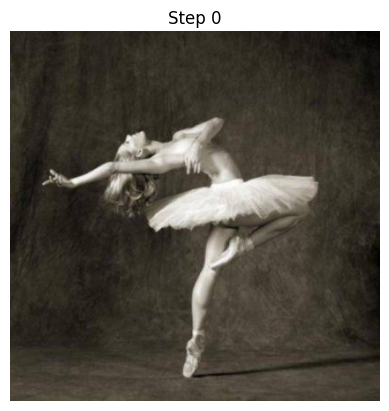

Step 50 | Style: 10.6050 | Content: 7.8191


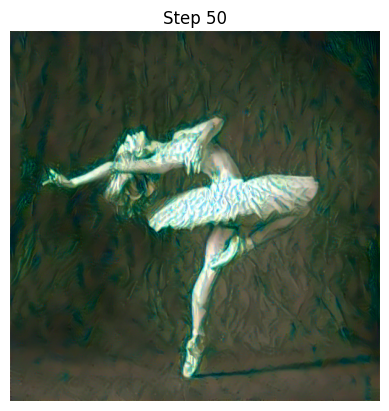

Step 100 | Style: 2.5607 | Content: 9.4797


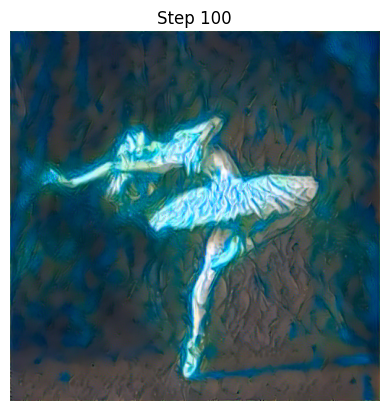

Step 150 | Style: 1.7271 | Content: 8.9496


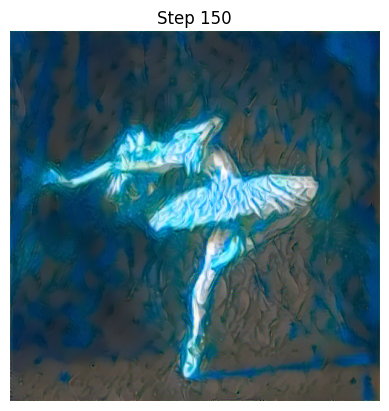

Step 200 | Style: 1.4366 | Content: 8.7599


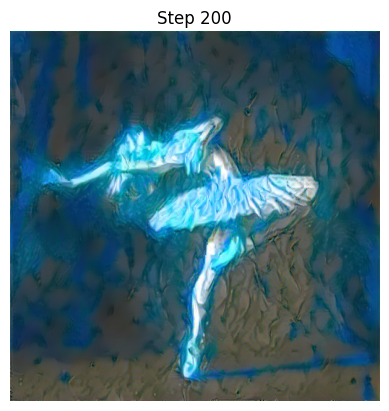

Step 250 | Style: 1.1840 | Content: 8.9255


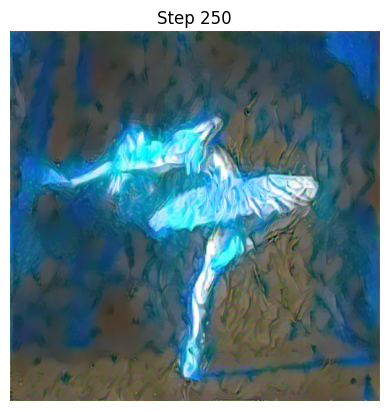

Step 300 | Style: 1.0203 | Content: 9.0450


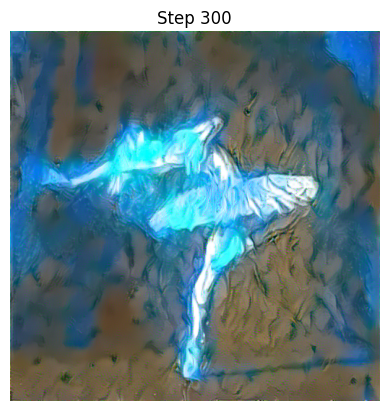

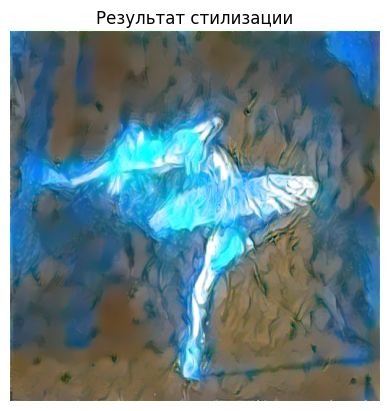

In [10]:

cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

input_img = content_img.clone()
input_img.requires_grad_(True)

model, style_losses, content_losses = get_style_model_and_losses(
    cnn, cnn_normalization_mean, cnn_normalization_std,
    style_img, content_img
)

optimizer = optim.LBFGS([input_img])
style_weight = 1e8
content_weight = 1e6

run = [0]
max_iter = 300
last_loss = float('inf')
loss_stable_counter = 0

def closure():
    global last_loss, loss_stable_counter
    input_img.data.clamp_(0, 1)
    optimizer.zero_grad()
    model(input_img)
    style_score = sum(sl.loss for sl in style_losses)
    content_score = sum(cl.loss for cl in content_losses)
    loss = style_weight * style_score + content_weight * content_score
    loss.backward()

    if run[0] % 50 == 0:
        print(f"Step {run[0]} | Style: {style_score.item():.4f} | Content: {content_score.item():.4f}")
        img = input_img.cpu().detach().squeeze().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Step {run[0]}")
        plt.show()

    if abs(loss.item() - last_loss) < 1e-4:
        loss_stable_counter += 1
    else:
        loss_stable_counter = 0
        last_loss = loss.item()

    if loss_stable_counter >= 10:
        run[0] = max_iter + 1
    else:
        run[0] += 1

    return loss

while run[0] <= max_iter:
    optimizer.step(closure)

input_img.data.clamp_(0, 1)
final_img = input_img.cpu().detach().squeeze().permute(1, 2, 0).numpy()
plt.imshow(final_img)
plt.title("Результат стилизации")
plt.axis('off')
plt.show()

Image.fromarray((final_img * 255).astype('uint8')).save("final_result.jpg")
